# Workload Characterization

## 1. Introduction
This notebook shows the characterization of a workload used to carry out performance analysis of a Linux system, aimed at discovering trends in resource usage.

**Workload characterization** is the process of creating a **synthetic workload**, representative of the real one. In other words, we want to extract a statistical model of the real workload that represent his variability.

The characterization is done through two different techniques: *principal component analyis* and *clustering*. 

### 1.1. Import relevant modules

In [1]:
# Data Analysis
import pandas as pd

# Data Visualization
from matplotlib import pyplot as plt

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

# Utilities
import numpy as np
import warnings

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
warnings.filterwarnings('ignore')

### 1.2. Read the dataset

In [4]:
df_rough = pd.read_csv('LL_raimondo.csv', sep = ';')
#df_rough.astype(float)
df_rough.head()
# print(df_rough.head().to_latex())

,r,b,swpd,free,buff,cache,si,so,bi,bo,in,cs,us,sy,id,wa
0,0,0,355372,203880,15320,370892,216,957,4389,1090,616,2127,9,60,30,0
1,0,0,355372,203880,15320,370892,0,0,0,0,348,823,10,16,74,0
2,0,0,355372,203880,15320,370892,0,0,0,0,275,156,1,2,96,0
3,0,0,355372,203880,15320,370892,0,0,0,0,275,146,0,1,99,0
4,4,0,355372,203880,15320,370892,0,0,0,0,495,225,1,77,22,0


In [5]:
print('The workload contains {:d} components and {:d} observations.'.format(df_rough.shape[1], df_rough.shape[0]))

The workload contains 16 components and 305 observations.


### 2.2. Normalize the components
Lastly, we standardize workload components so that they have mean and variance respectively equal to 0 and 1.

In [6]:
x = df_rough.values

x_scaled = StandardScaler().fit_transform(x)

df_scaled = pd.DataFrame(data=x_scaled, columns=df_rough.columns )
df_scaled = df_scaled.astype(float)
df_scaled.head()
#df_scaled.dtypes

,r,b,swpd,free,buff,cache,si,so,bi,bo,in,cs,us,sy,id,wa
0,-0.970034,-0.129099,1.787175,1.059695,-1.541975,-1.321085,10.937933,17.435596,5.087844,12.962854,0.444593,9.280346,3.656962,-1.274613,0.925410,-0.081244
1,-0.970034,-0.129099,1.787175,1.059695,-1.541975,-1.321085,-0.161060,-0.057354,-0.125005,-0.152676,-0.407083,2.471213,4.187839,-3.315820,2.997663,-0.081244
2,-0.970034,-0.129099,1.787175,1.059695,-1.541975,-1.321085,-0.161060,-0.057354,-0.125005,-0.152676,-0.639070,-1.011680,-0.590057,-3.965294,4.033789,-0.081244
3,-0.970034,-0.129099,1.787175,1.059695,-1.541975,-1.321085,-0.161060,-0.057354,-0.125005,-0.152676,-0.639070,-1.063897,-1.120934,-4.011685,4.175079,-0.081244
4,-0.138966,-0.129099,1.787175,1.059695,-1.541975,-1.321085,-0.161060,-0.057354,-0.125005,-0.152676,0.060067,-0.651381,-0.590057,-0.485965,0.548637,-0.081244


In [7]:
df_princ_comp = pd.read_csv('LL_pca.csv', sep = ';', decimal=",")
df_princ_comp = df_princ_comp.astype(float)
df_princ_comp.head()

,Principale1,Principale2,Principale3,Principale4,Principale5,Principale6,Principale7,Principale8,Principale9,Principale10
0,5.449818,25.824625,1.726655,-1.972047,0.210016,-2.312368,-1.729676,1.578032,-0.556199,-1.792968
1,4.962553,1.164982,1.471181,-2.193485,-0.219916,1.477957,2.947507,-2.364746,1.188535,0.429269
2,5.025424,-1.423277,3.140288,-1.572152,0.580288,-0.008309,-0.122201,1.142396,0.296047,-0.552254
3,5.023473,-1.564044,3.294675,-1.496402,0.711909,-0.197656,-0.476333,1.371159,0.344980,-0.586089
4,2.760811,-0.777958,-0.557803,0.492108,0.164496,-0.393703,-0.445748,0.542956,-0.095091,-0.225927


In [8]:
# TEST per verificare che tutte le componenti ottenute forniscano un contributo non nullo alla devianza totale
dev_tot = df_princ_comp.pow(2).sum().sum()
print('Devianza totale', dev_tot)

Devianza totale 4622.875783450541


## 4. Clustering 
After reducing the workload dimensionality (number of columns), we want too reduce his dimension too (number of rows). 
A way to do this is by using **clustering**, which is the process of grouping a set of items in such a way that items in the same group are more similar to each other than to those in other groups.
Once found groups of items, also called **clusters**, we can build a new workload that will contain one item for each cluster.

Among the different clustering techniques, we choose an agglomerative approach called **Ward's method**, which is an hierarchical clustering method that minimize *intra-cluster deviance*. By minimizing the intra-cluster deviance we are also minimizing the *intra-cluster variance*, that is the variance that we lost applying the clustering process.

Basically, Ward's method builds clusters iteratively by merging at each iteration the two closest cluster. Distance between two clusters $P$ and $Q$ is measured through a metric called *Ward distance*, defined as:<br>
<center>$d(P,Q) = 2 \frac{|P||Q|}{|P|+|Q|} ||\overline x_P- \overline x_Q||^2$</center>  

where $|Q|$ is the cardinality of cluster $Q$ and $\overline x_Q$ is his  *centroid*, defined as:<br>
<center>$\overline x_Q = \frac{1}{|Q|} \sum_{i=1}^{|Q|}x_i$</center>

where $x_i$ is the i-th point of cluster $Q$.

### 4.1. Select principal components
First of all let's define the data we want to cluster. As said before, we can consider only the first few principal components. Let's consider the firts three components, which explain the 84% of the dataset variance.

In [9]:
n_comp = 10

df_clustering = df_princ_comp.iloc[:,0:n_comp]
df_clustering.head()

,Principale1,Principale2,Principale3,Principale4,Principale5,Principale6,Principale7,Principale8,Principale9,Principale10
0,5.449818,25.824625,1.726655,-1.972047,0.210016,-2.312368,-1.729676,1.578032,-0.556199,-1.792968
1,4.962553,1.164982,1.471181,-2.193485,-0.219916,1.477957,2.947507,-2.364746,1.188535,0.429269
2,5.025424,-1.423277,3.140288,-1.572152,0.580288,-0.008309,-0.122201,1.142396,0.296047,-0.552254
3,5.023473,-1.564044,3.294675,-1.496402,0.711909,-0.197656,-0.476333,1.371159,0.344980,-0.586089
4,2.760811,-0.777958,-0.557803,0.492108,0.164496,-0.393703,-0.445748,0.542956,-0.095091,-0.225927


Performing clustering after PCA has two decisive advantages:
1. Clustering is applyed to a dataset with fewer components.
2. It prevents errors in clustering, since components computed by PCA are uncorrelated.

### 4.2. Perform clustering
For now, let's suppose we want to cluster our dataset in 10 groups. We can perform clustering using the model AgglomerativeClustering, provided by scikit-learn. By default, the distance metric used by the algorithm is Ward's distance.

In [10]:
df_clus = pd.read_csv('LL_cluster.csv', sep = ';')
df_clus.astype(int)
df_clus.head()
n_clusters = df_clus['Cluster'].max()
df_clus['Cluster'] -= 1
print(n_clusters)
df_clustered = df_rough
df_clustered.loc[:,'cluster'] = df_clus['Cluster']
df_clustered


20


,r,b,swpd,free,buff,cache,si,so,bi,bo,in,cs,us,sy,id,wa,cluster
0,0,0,355372,203880,15320,370892,216,957,4389,1090,616,2127,9,60,30,0,0
1,0,0,355372,203880,15320,370892,0,0,0,0,348,823,10,16,74,0,6
2,0,0,355372,203880,15320,370892,0,0,0,0,275,156,1,2,96,0,1
3,0,0,355372,203880,15320,370892,0,0,0,0,275,146,0,1,99,0,1
4,4,0,355372,203880,15320,370892,0,0,0,0,495,225,1,77,22,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,6,0,354920,147888,15848,402008,0,0,0,12,275,368,1,99,0,0,14
301,1,0,354920,147888,15848,402012,0,0,0,0,286,360,2,98,0,0,14
302,7,0,354920,147888,15848,402012,0,0,0,0,291,404,1,99,0,0,14
303,7,0,354920,147888,15856,402012,0,0,0,24,278,378,1,99,0,0,14


## 5. Deviance
As we already said, we want a synthetic workload to be representative of the real one, in term of variability of the data. For this reason, we need to observ how both techniques used in the characterization process affect the worload variance.

Let's start by computing the total deviance of the workload.

In [11]:
dev_tot = df_scaled.sub(df_scaled.mean()).pow(2).sum().sum()
dev_tot

4880.0

### 5.1. Deviance after PCA
Now let's compute the deviance preserved by PCA.

In [14]:
df_princ_comp = df_princ_comp.iloc[:,0:n_comp]
print(df_princ_comp)
dev_pca = df_princ_comp.sub(df_princ_comp.mean()).pow(2).sum().sum()


     Principale1  Principale2  Principale3  Principale4  Principale5  \
0       7.128438    14.937301     9.463776     3.803223    -1.482101   
1       2.191101     3.386964     3.307521     1.834737    -2.062922   
2       0.836816     3.407830     2.935573     0.526316    -1.471354   
3      -0.408389     5.250780     2.467732     1.085657    -1.697331   
4       2.143690     2.159051     1.949318     1.674635    -1.919662   
..           ...          ...          ...          ...          ...   
300     4.450264    -0.265985    -2.878629     0.271073     0.845547   
301     5.571863     0.057422    -4.547450    -0.098990     1.743804   
302     5.749571     0.224054    -4.610839    -0.042537     1.835743   
303     5.694403    -0.084663    -5.133150    -0.130215     2.099691   
304     4.481734    -0.286952    -3.069665     0.119169     0.850072   

     Principale6  Principale7  Principale8  Principale9  Principale10  
0      -1.367571    -4.155226    -1.973137    -0.338776      0.

In [16]:
print(dev_pca)
dev_pca_ratio = dev_pca/dev_tot
dev_pca_ratio

4579.847001632744


0.9384932380394967

As expected, considering just three of the principal components, we are including the 84% of the total deviance.

### 5.2. Deviance after clustering
Now we can see how clustering affects deviance of data. First of all, total deviance of clustered data (deviance after PCA) can be written as:<br>
<center>$d_{PCA} = d_{intra} + d_{inter}$</center>

where $d_{intra}$ and $d_{inter}$ are called respectively *intra-cluster deviance* and *inter-cluster deviance*.
Since we consider just one random point for each cluster, $d_{intra}$ is the amount of deviance lost form PCA deviance, whereas $d_{inter}$ it the amount of deviance preserved.

#### Intra-cluster deviance
Intra-cluster deviance is the sum of the deviance of each cluster:<br>
<center>$d_{intra} = \sum_{k=1}^{K} \sum_{i=1}^{n_k} ||x_i - \overline x_k||$</center>

where:
- $K$ is the number of clusters
- $n_k$ is the number of points of cluster $k$
- $x_i$ is the $i$-th point of cluster $k$
- $\overline x_k$ is the centroid of cluster $k$

In [17]:
df_clustering.loc[:,'cluster'] = df_clus['Cluster']
n_elem = df_clustering.groupby('cluster').count().values[:,0]
centroids = df_clustering.groupby('cluster').mean()

In [18]:
arr = np.zeros(shape=(n_clusters,1))

for i in range(n_clusters):
    elem_i = df_clustering.loc[df_clustering['cluster'] == i].drop(columns='cluster')
    arr[i] = elem_i.sub(centroids.loc[i,:]).pow(2).sum().sum()
    
dev_intra = arr.sum()
dev_intra

506.3067660929429

In [19]:
dev_intra_ratio = dev_intra/dev_pca
dev_intra_ratio

0.11055102188183173

#### Inter-cluster deviance
Inter-cluster deviance is defined as:<br>
<center>$d_{inter} = \sum_{k=1}^{K} n_k ||\overline x_k - \overline x||$</center>

where:
- $K$ is the number of clusters
- $n_k$ is the number of points of cluster $k$
- $\overline x_k$ is the centroid of cluster $k$
- $\overline x_ = \frac{1}{n} \sum_{i=1}^{n} x_i$ is the mean of all data points.

In [20]:
dev_inter = centroids.sub(df_clustering.mean()).pow(2).mul(n_elem, axis=0).sum().sum()
dev_inter

4073.540235539801

In [21]:
dev_inter_ratio = dev_inter/dev_pca
dev_inter_ratio

0.8894489781181683

Before moving forward, let's check that the sum of intra and inter-cluster deviance is equal to the deviance preserved by PCA.

In [22]:
print('dev_intra + dev_inter = ' + str(dev_intra + dev_inter))
print('dev_pca = ' + str(dev_pca))

dev_intra + dev_inter = 4579.847001632744
dev_pca = 4579.847001632744


### 5.3. Loss of deviance
Finally we can compute the total loss of deviance due to both PCA and clustering.

#### 1st approach 
Deviance lost can be seen as the sum of deviance lost because of PCA and deviance lost because of clustering (intra-cluster deviance), which is relative to deviance preserved by PCA.

In [23]:
dev_lost_ratio = (1-dev_pca_ratio) + dev_intra_ratio * dev_pca_ratio
dev_lost_ratio

0.16525814845495884

#### 2nd approach
Deviance lost can be seen as total deviance minus total deviance preserved, which is the product of deviance preserved by PCA and deviance preserved by clustering (inter-cluster deviance).

In [24]:
dev_lost_ratio = 1 - dev_inter_ratio * dev_pca_ratio
dev_lost_ratio

0.1652581484549588

## 6. Trade-off
On one hand the dimension reduction of the workload depends on the number of clusters. On the other hand the loss of deviance caused by PCA and clustering depends not only on the cluster's number but also on the number of principal components. For this reason, we need to find the number of clusters and components that ensure the best trade-off between deviance lost and dimension reduction.

### 6.1. Deviance lost
To see how deviance changes depending on those parameters, we execute all the steps shown in the previous sections for different numbers of principal components and clusters. We vary component's number from 3 (84% of explained variance) to 6 (95% of explained variance) and cluster's number from 1 to 20.

In [25]:
nmin_comp = 5
nmax_comp = 10
n_comp = nmax_comp-nmin_comp+1

nmax_cluster = 25

array_dev_lost = np.zeros(shape=(nmax_cluster,n_comp))

for i in range(nmin_comp,nmax_comp+1):
    for j in range(1,nmax_cluster+1):
        
        df_clustering = df_princ_comp.iloc[:,0:i]
            
        # clustering
        clustering = AgglomerativeClustering(n_clusters=j)
        clustering = clustering.fit(df_clustering.values)
        df_clustering.insert(len(df_clustering.columns), 'cluster', clustering.labels_)

        # deviance PCA
        df_pca = df_princ_comp.iloc[:,0:i]
        dev_pca = df_pca.sub(df_pca.mean()).pow(2).sum().sum()

        # deviance clustering 
        n_elem = df_clustering.groupby('cluster').count().values[:,0]
        centroids = df_clustering.groupby('cluster').mean()

        # intra-cluster deviance
        arr = np.zeros(shape=(j,1))
        for k in range(j):
            elem_k = df_clustering.loc[df_clustering['cluster'] == k].drop(columns='cluster')
            arr[k] = elem_k.sub(centroids.loc[k,:]).pow(2).sum().sum()
        dev_intra = arr.sum()

        # inter-cluster deviance
        dev_inter = centroids.sub(df_clustering.mean()).pow(2).mul(n_elem, axis=0).sum().sum()
        dev_inter

        # deviance lost
        dev_pca_ratio = dev_pca/dev_tot
        dev_inter_ratio = dev_inter/dev_pca
        dev_lost = 1 - dev_inter_ratio * dev_pca_ratio

        array_dev_lost[j-1][i-n_comp+1] = dev_lost
                
# array_dev_lost

Now we can see how the deviance changes depending on number of clusters, for different numbers of principal components.

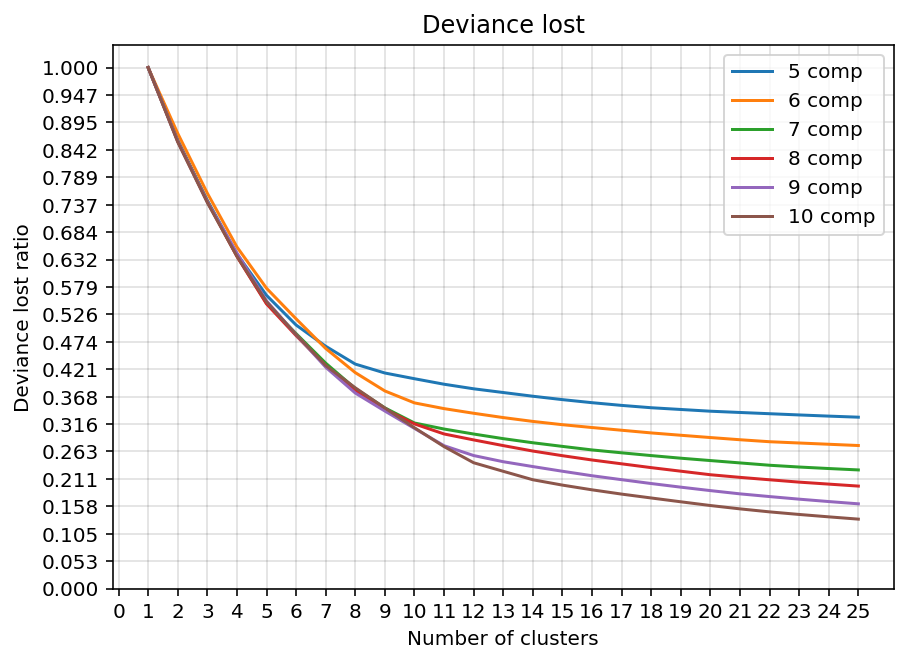

In [26]:
x = np.arange(1,nmax_cluster+1)

plt.figure(figsize=(7,5))

for i in range(nmin_comp,nmax_comp+1):
    y_dev_lost = array_dev_lost[:,i-n_comp+1]
    plt.plot(x, y_dev_lost)
    
c = [str(s) for s in range(nmin_comp,nmax_comp+1)]
c = [s + ' comp' for s in c]
    
plt.title('Deviance lost')
plt.ylabel('Deviance lost ratio')
plt.xlabel('Number of clusters')
plt.xticks(range(nmax_cluster+1))
plt.yticks(np.linspace(0,y_dev_lost.max(),20))
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.legend(c)
plt.savefig("varpersaLL_sint.svg", format = "svg")
plt.show()


As we can see, the deviance lost decreases with the rise of clusters number, regardless of the number of principal components. It is reasonable since increasing the number of clusters we are considering more data points.
Anyway, the deviance lost doesn't decrease linearly, as the curve settles down once reached 6 clusters.

Moreover, if the number of clusters is smaller than 6, the deviance lost does not depend too much on principal compontens number. On the contrary, if clusters are 6 or more than 6, it decreases as the number of components grows. For istance, with 6 clusters, the difference between choosing 3 or 6 compontents is 5%, in term of deviance lost.

### 6.2. Dimension reduction
Dimension reduction of workload can be measure looking at the ratio between number of values (number of columns times number of rows) of the synthetic workload and number of values of the real one. As we already said, reduction depends only on the number of clusters, as the synthetic workload dimension increase linearly with the number of clusters.

In [27]:
dim_synt = np.arange(1,nmax_cluster+1)*df_rough.shape[1]
dim_real = df_rough.size

array_dim = dim_synt/dim_real
array_dim

array([0.00327869, 0.00655738, 0.00983607, 0.01311475, 0.01639344,
       0.01967213, 0.02295082, 0.02622951, 0.0295082 , 0.03278689,
       0.03606557, 0.03934426, 0.04262295, 0.04590164, 0.04918033,
       0.05245902, 0.0557377 , 0.05901639, 0.06229508, 0.06557377,
       0.06885246, 0.07213115, 0.07540984, 0.07868852, 0.08196721])

### 6.3. Deviance vs Dimension
Ideally, we want both deviance lost and synthetic workload dimension to be as small as possible. The former decrease with the number of clusters (and principal components) but the latter increase with the same parameter. For this reason, we can consider the product of those quantities and look for the values of clusters and components that minimize this product.

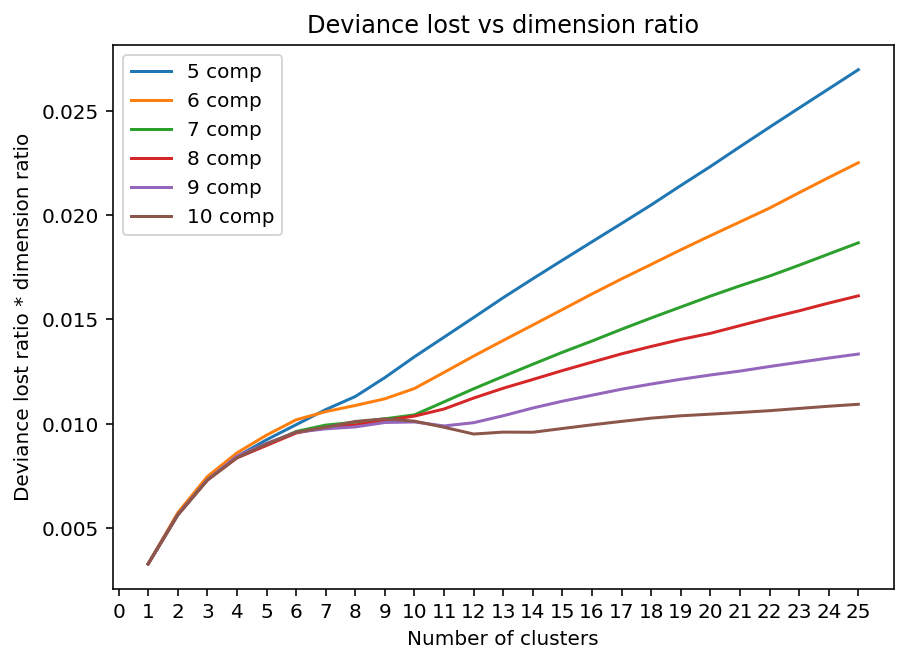

In [28]:
x = np.arange(1,nmax_cluster+1)
y_dim = array_dim

plt.figure(figsize=(7,5))

for i in range(nmin_comp,nmax_comp+1):
    y_dev_lost = array_dev_lost[:,i-n_comp+1]
    plt.plot(x, y_dim*y_dev_lost)

c = [str(s) for s in range(nmin_comp,nmax_comp+1)]
c = [s + ' comp' for s in c]
    
plt.title('Deviance lost vs dimension ratio')
plt.ylabel('Deviance lost ratio * dimension ratio')
plt.xlabel('Number of clusters')
plt.xticks(range(nmax_cluster+1))
plt.legend(c)
plt.savefig("prod_var_dimLL_sint.svg", format = "svg")
plt.show()

In [29]:
array_dev_lost

array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ],
       [0.86032074, 0.8736333 , 0.85938049, 0.85852999, 0.85842421,
        0.85689634],
       [0.74498643, 0.75881039, 0.74339126, 0.74246479, 0.74231796,
        0.74074057],
       [0.64232154, 0.65573076, 0.63839673, 0.63746912, 0.64387292,
        0.63811899],
       [0.56285876, 0.57643688, 0.54761678, 0.54638769, 0.55217644,
        0.55058872],
       [0.50587375, 0.51772049, 0.48933292, 0.48552351, 0.48759142,
        0.48758705],
       [0.46510559, 0.46086639, 0.43273613, 0.42797983, 0.42488734,
        0.4280362 ],
       [0.43088076, 0.41450957, 0.38385677, 0.37885277, 0.37532389,
        0.385366  ],
       [0.41377839, 0.37932252, 0.34682627, 0.34427609, 0.34077954,
        0.34664144],
       [0.40281726, 0.35642623, 0.31785308, 0.31607327, 0.30749985,
        0.30869321],
       [0.39225213, 0.34543197, 0.30626192, 0.29679217, 0.27426586,
        0.27249648],
       [0.38348636, 0

Looking at the above plot, we can draw the following conclusions:
- If we want the least number of principal components that preserve a good amount of deviance, we should choose 3 components and 5 clusters;
- If we can affoard an higher number of principal components, we should choose 5 components and 6 clusters.

Anyway, we want highlight that the number of principal components and clusters depend heavily on resources available for the characterization itself and the performance analysis.